In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
import kagglehub
import random
import os
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def show_image(tensor, title=''):
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Работаем на устройстве: {DEVICE}')

Работаем на устройстве: cuda


In [31]:
EMBEDDING_SIZE = 128
MARGIN = 0.2
BATCH_SIZE = 2

path = kagglehub.dataset_download("atulanandjha/lfwpeople")

In [32]:
!mkdir -p ./data/lfw_funneled
!tar -xvzf /kaggle/input/lfwpeople/lfw-funneled.tgz -C ./data/


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

Выходные данные были обрезаны до нескольких последних строк (5000).
lfw_funneled/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken

In [33]:
full_dataset = ImageFolder(root='./data/lfw_funneled', transform=transform)

# Выбираем только первых 30 людей
selected_classes = full_dataset.classes[:30]
print('Выбранные люди:', selected_classes)

selected_idx = [idx for idx, (path, label) in enumerate(full_dataset.samples)
                if full_dataset.classes[label] in selected_classes]

Выбранные люди: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even']


In [34]:
dataset = Subset(full_dataset, selected_idx)

print(f'Итоговый размер датасета: {len(dataset)} изображений')

Итоговый размер датасета: 67 изображений


In [35]:
class ResNet18Embedding(nn.Module):
    def __init__(self, embedding_size=EMBEDDING_SIZE):
        super(ResNet18Embedding, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.embedding_layer = nn.Linear(resnet.fc.in_features, embedding_size)

    def forward(self, x):
        x = self.feature_extractor(x).squeeze()
        x = self.embedding_layer(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [36]:
class TripletLoss(nn.Module):
    def __init__(self, margin=MARGIN):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = F.pairwise_distance(anchor, positive, p=2)
        neg_distance = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()

# Генерация Triplet Dataset
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = [label for _, label in dataset]

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        positive_idx = idx
        while positive_idx == idx or self.labels[positive_idx] != anchor_label:
            positive_idx = random.randint(0, len(self.dataset) - 1)

        negative_idx = idx
        while self.labels[negative_idx] == anchor_label:
            negative_idx = random.randint(0, len(self.dataset) - 1)

        positive_img, _ = self.dataset[positive_idx]
        negative_img, _ = self.dataset[negative_idx]

        return anchor_img, positive_img, negative_img, anchor_label

    def __len__(self):
        return len(self.dataset)

In [37]:
model = ResNet18Embedding().to(DEVICE)
triplet_loss_fn = TripletLoss()

triplet_dataset = TripletDataset(dataset)
loader = DataLoader(triplet_dataset, batch_size=BATCH_SIZE, shuffle=True)

Начинаем обучение модели...
Triplet Loss: 0.1030
Пара №1


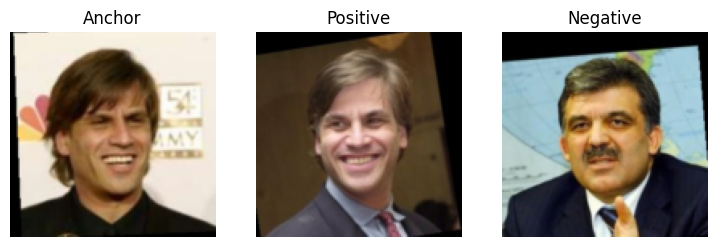

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print('Начинаем обучение модели...')

model.train()

for batch in loader:
    anchor, positive, negative, labels = batch
    anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)

    anchor_embed = model(anchor)
    positive_embed = model(positive)
    negative_embed = model(negative)
    loss = triplet_loss_fn(anchor_embed, positive_embed, negative_embed)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Triplet Loss: {loss.item():.4f}')

    for i in range(1):
      print(f'Пара №{i+1}')
      plt.figure(figsize=(9,3))

      plt.subplot(1, 3, 1)
      show_image(anchor[i], title='Anchor')

      plt.subplot(1, 3, 2)
      show_image(positive[i], title='Positive')

      plt.subplot(1, 3, 3)
      show_image(negative[i], title='Negative')

      plt.show()

    break